# 📖 이미지에 스티커 붙이기
## 🔎문제정의
- Input: 얼굴이 포함된 이미지
- body
  1. 얼굴의 위치를 detection 한다
  2. 이목구비의 landmarks를 detection 한다
  3. 이목구비의 landmarks를 적절히 계산하여 원하는 위치에 스티커 이미지를 위치시킨다
  4. 원 이미지를 스티커 이미지의 원하는 픽셀로 덮어쓴다
- output: 얼굴에 스티커를 붙인 이미지

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import dlib

In [3]:
my_image_path = './data/camera_sticker/images/IU_rotate.jpeg'
img_bgr = cv2.imread(my_image_path, cv2.IMREAD_COLOR)

# img_bgr = cv2.resize(img_bgr, (500, 750))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_show = img_bgr.copy() # ndarray는 copy 하면 같은 아이디를 안 가지는구나

#img_show_test = img_bgr
# assert id(img_show_test) == id(img_bgr), "두개는 같아!"

# plt.imshow(img_rgb)
# plt.imshow(img_show)

# FACE DETECTION

- [Trouble] 얕은복사
  - copy와 재할당 issue: list를 변수명이 아닌 슬라이스로 복사할 경우 얕은 복사가 되는데, 이때 **재할당**을 이용하면 문제가 없으나, **값 변경**을 이용하면 여전히 연결된 두 리스트가 동시에 변하는 side effect가 발생한다. 값 변경을 주의할 것.

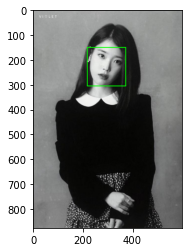

In [4]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)
dlib_rects

for dlib_rect in dlib_rects:
    x1 = dlib_rect.left()
    y1 = dlib_rect.top()
    x2 = dlib_rect.right()
    y2 = dlib_rect.bottom()
cv2.rectangle(img_show, (x1, y1), (x2, y2), (0, 255, 0), 2, lineType=cv2.LINE_AA)
#값 변경이 아닌 재할당을 하고 있구나; 이 함수가!

rgb_img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img_show)

# LOCALIZATION MODEL
- 이목구비의 위치를 인식하는 부분이다.

68


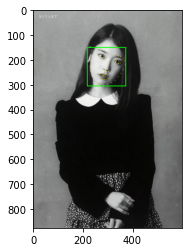

In [5]:
model_path = './data/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects :
    fod = landmark_predictor(img_rgb, dlib_rect)

list_points = list(map( lambda p : (p.x, p.y ), fod.parts()))
list_landmarks.append(list_points)
print(len(list_landmarks[0]))

# for landmark in list_landmarks:
for idx, point in enumerate(list_points):
    cv2.circle(img_show, point, 1, (0, 255, 255), -1) # yellow
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)

# 😼고양이 스티커 삽입
- 이때 목표는 스티커의 검은색 부분(0, 0, 0, 255)만이 원래 이미지를 대체하도록 하는 것이다.

- [Trouble] 이미지의 좌표 x, y와 이미지의 Array의 인덱스
  - 이미지 상의 좌표는 좌상단을 (0, 0)으로 해서 → x 증가, ↓y 증가 하는 꼴을 띤다
  - 이미지 Array도 이와 같아서 0번째 인덱스는 y의 증가를 가리키고, 1번째 인덱스는 x의 증가를 가리킨다.
- [Trouble] Distance: 사진 상 사람의 크기 문제
  - 사람이 멀어지면 얼굴이 작아진다. 그러므로 고양이 코의 크기를 비례적으로 resize해야한다.

297 234
(78, 78, 4)


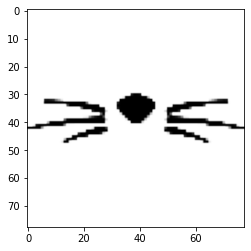

In [6]:
#dlib_rects: hog로 뽑아낸 bounding box
#list_landmarks: shape_predictor로 뽑아낸 이목구미 점들의 집합
# for dlib_rect, landmark in zip(dlib_rects, list_landmarks):

dlib_rect = dlib_rects[0]
landmark = list_landmarks[0]

x, y = landmark[30] # nose center idx : 33
print(x, y)
# y -= dlib_rect.height()//2
w = dlib_rect.width()
h = dlib_rect.height()

stirkcer_path = './data/camera_sticker/images/catwhisker.png'

img_sticker = cv2.imread(stirkcer_path, cv2.IMREAD_UNCHANGED )
img_sticker = cv2.resize(img_sticker, (w//2,h//2)) #가로, 세로 순서
w = w//2
h = h//2

print(img_sticker.shape)
plt.imshow(img_sticker)

- [Trouble] Rotation: 얼굴 각도 문제
  - 이미지가 회전한 경우 어떻게 할 것인가 ?
  - 이미지의 눈썹의 양끝 점을 이용해 기울기를 구하고 각도로 변환하여 회전시킨다.
    - slope = $\frac{y_1 - y_2}{x_2 - x_1} * 45˚$
  - 이때, warpAffine의 borderValue옵션을 이용해 새로운 흰색 배경의 네모를 만든다.
  - 그럼 나머지는 기존과 동일하다 !!

256 160 367 204
-17.83783783783784


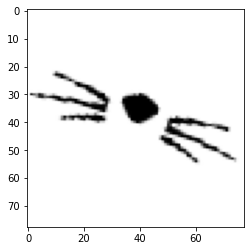

In [7]:
def rotate(img, angle, rotPoint = None):
    (height, width) = img.shape[:2]
    
    if rotPoint is None:
        rotPoint = (width // 2, height //2)
        
    rotMat = cv2.getRotationMatrix2D(rotPoint, angle, 1.0)
    dimensions = (width, height)
    
    return cv2.warpAffine(img, rotMat, dimensions, borderValue=(255,255,255, 0))

x1, y1 = landmark[17] # 왼쪽 눈썹 끝의 위치
x2, y2 = landmark[26] # 오른쪽 눈썹 끝의 위치
print(x1, y1, x2, y2)
slope = ( (y1-y2) / (x2-x1) ) * 45
print(slope)
img_sticker = rotate(img_sticker, slope)
plt.imshow(img_sticker)

- BGRA파일인 img_sticker와 비교하기 위해 img_show를 BGRA로 변환한다. 이때, 투명도 A값은 최대인 255로 한다.

In [8]:
# img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2BGRA)
b_channel, g_channel, r_channel = cv2.split(img_show)
alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype)*255 #creating a dummy alpha channel image.
img_show = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
# plt.imshow(img_show)

- 그 결과로 만든 img_show(BGRA)로 부터 관심영역인 sticker_area를 잘라낸다. 이때 인덱스와 좌표의 반전관계를 유의하자.

In [9]:
#원 이미지 크롭
start_y = y - w//2 ; end_y = start_y + img_sticker.shape[1]
start_x = x - w//2 ; end_x = start_x + img_sticker.shape[0]
sticker_area = img_show[ start_y : end_y, start_x : end_x ]

In [1]:
# 잘 잘려나온 것을 볼 수 있다.
# for i in sticker_area :
#     for j in i :
#         if (j != 0).any():
#             print(j)
# plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGRA2RGBA))

- 그리고 출력하고자 하는 img_show의 관심영역을 img_sticker값으로 치환하자

In [11]:
img_show[  start_y : end_y, start_x : end_x ]= \
    np.where(img_sticker != 0, sticker_area, img_sticker).astype(np.uint8)

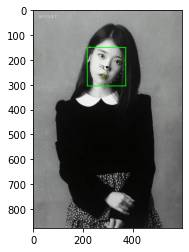

In [12]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGRA2RGB))
plt.show()

# 🎉완성되었다!

- bounding box와 face detection points가 없는 깨끗한 이미지에 스티커만 추가하자.

In [13]:
#원 이미지 크롭
b_channel, g_channel, r_channel = cv2.split(img_bgr)
alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype)*255 #creating a dummy alpha channel image.
img_bgr = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))

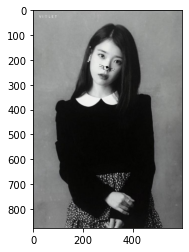

In [14]:
sticker_area = img_bgr[ start_y : end_y, start_x : end_x ]

img_bgr[ start_y : end_y, start_x : end_x ]= \
    np.where(img_sticker != 0, sticker_area, img_sticker).astype(np.uint8)

img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_BGRA2RGB)
plt.imshow(img_bgr)
plt.show()

- 해결하지 못한 문제
  - plt.show(cv2.cvtColor(img_bgr, cv2.COLOR_BGRA2RGB)): 정상적인 그림과 plt.show(cv2.cvtColor(img_bgr, cv2.COLOR_BGRA2RGBA)): 흰색 박스가 나오는 그림의 차이는 대체 뭐길래 이렇게 표현되는걸까.

# 루브릭 기준
1. 자기만의 카메라앱 기능 구현을 완수하였다.
2. 스티커 이미지를 정확한 원본 위치에 반영하였다.
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.
  - 얼굴 각도, 촬영 거리 등

# 📘 회고

- 이번 과제를 진행하면서 익숙하지 않은 이미지 좌표와 array의 관계로 인해 애를 먹었다. 그 이외에도 mutable객체의 복사와 관련해서 변수명이 아닌 슬라이스로 복사를 하더라도 단순히 변수명의 id만 다르고 내부 원소의 id는 같은 얕은 복사가 일어나며, 이때 재할당을 하면 문제가 없으나 값 변경을 하면 문제가 생기는 것을 발견하였다. 이 두가지 문제로 인해 많은 시간을 소모하였다.
- Open cv의 익숙하지 못한 사용으로 인해 고생하였으나, cv tutorial을 이용해 많은 시간을 단축할 수 있었다. 또한 함수를 적용할 때 필요한 기능이 있으면 그 옵션을 뒤져보면 있을 가능성이 높다는 것을 알게 되었다.(wrapAffine의 borderValue)
- 하지만 여전히 BGRA2를 RGB로 변경하면 정상적인 그림이 나오고 RGBA로 변경하면 흰색 박스(255, 255, 255, 255)가 생기는 문제는 해결하지 못했다. 실마리도 없다.
- 루브릭 3번을 맞추기 위해 다양한 시도를 하였고, resize와 rotation을 통해 성공적으로 수행하였다.
- 프로그래밍은 구현이다. 먼저 구현을 할 수 있게 되면 이론을 이해하기가 쉬워진다는 것을 알게되었다.
- 따라서 최대한 많은 필사를 하면서 코드가 작동하는 방식을 받아들이려고 노력해야 겠다고 생각을 했다.